In [1]:
# ==================================================
# CELL 1: Import Libraries and Load Labeled Dataset
# ==================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re

# Text processing libraries
import string
from collections import Counter

warnings.filterwarnings('ignore')
%matplotlib inline

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

print("="*70)
print("🧹 NOTEBOOK 3: DATA CLEANING & TEXT PREPROCESSING")
print("="*70)

# Load the labeled dataset we created in Notebook 2
data_path = '../data/processed/complaints_labeled.csv'
print(f"\n🔄 Loading labeled dataset from: {data_path}")
print("This may take 30-60 seconds...")

df = pd.read_csv(data_path, low_memory=False)

print(f"\n✅ Dataset loaded successfully!")
print(f"   • Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"   • Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n" + "="*70)

🧹 NOTEBOOK 3: DATA CLEANING & TEXT PREPROCESSING

🔄 Loading labeled dataset from: ../data/processed/complaints_labeled.csv
This may take 30-60 seconds...

✅ Dataset loaded successfully!
   • Shape: 769,883 rows × 17 columns
   • Memory: 858.22 MB



In [2]:
# ==================================================
# CELL 2: Analyze Current Data Quality
# ==================================================

print("🔍 DATA QUALITY ASSESSMENT")
print("="*70)

print("\n📊 Dataset Overview:")
print(f"   • Total records: {len(df):,}")
print(f"   • Total columns: {df.shape[1]}")

print("\n📋 Column Information:")
print("-"*70)
df.info()

print("\n" + "="*70)

🔍 DATA QUALITY ASSESSMENT

📊 Dataset Overview:
   • Total records: 769,883
   • Total columns: 17

📋 Column Information:
----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 769883 entries, 0 to 769882
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   dispute_resolution            769883 non-null  object
 1   Product                       769883 non-null  object
 2   Sub-product                   535892 non-null  object
 3   Issue                         769883 non-null  object
 4   Sub-issue                     315492 non-null  object
 5   Consumer complaint narrative  156563 non-null  object
 6   Company                       769883 non-null  object
 7   State                         764092 non-null  object
 8   ZIP code                      764054 non-null  object
 9   Tags                          108091 non-nu

In [3]:
# ==================================================
# CELL 3: Detailed Missing Values Analysis
# ==================================================

print("🔍 MISSING VALUES ANALYSIS")
print("="*70)

# Calculate missing values
missing_count = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

# Create detailed missing values report
missing_df = pd.DataFrame({
    'Column': missing_count.index,
    'Missing_Count': missing_count.values,
    'Missing_Percent': missing_percent.values,
    'Data_Type': df.dtypes.values
})

# Sort by missing percentage
missing_df = missing_df.sort_values('Missing_Percent', ascending=False)

print("\n📊 Missing Values Report:\n")
print(missing_df.to_string(index=False))

print("\n" + "="*70)

# Identify columns with high missing percentages
high_missing = missing_df[missing_df['Missing_Percent'] > 50]

if len(high_missing) > 0:
    print(f"\n⚠️ COLUMNS WITH >50% MISSING VALUES:")
    print("-"*70)
    for idx, row in high_missing.iterrows():
        print(f"   • {row['Column']}: {row['Missing_Percent']:.2f}% missing")
    print("\n   → These columns might not be useful for modeling")
else:
    print("\n✅ No columns with >50% missing values")

print("\n" + "="*70)

🔍 MISSING VALUES ANALYSIS

📊 Missing Values Report:

                      Column  Missing_Count  Missing_Percent Data_Type
                        Tags         661792        85.960074    object
Consumer complaint narrative         613320        79.664053    object
  Consumer consent provided?         483729        62.831495    object
                   Sub-issue         454391        59.020786    object
                 Sub-product         233991        30.393060    object
          Consumer disputed?           7028         0.912866    object
                    ZIP code           5829         0.757128    object
                       State           5791         0.752192    object
          dispute_resolution              0         0.000000    object
                     Company              0         0.000000    object
                       Issue              0         0.000000    object
                     Product              0         0.000000    object
               Submitted

In [4]:
# ==================================================
# CELL 4: Identify Complaint Narrative Text Column
# ==================================================

print("📝 IDENTIFYING COMPLAINT NARRATIVE COLUMN")
print("="*70)

# Find the narrative/text column
narrative_col = None
possible_names = ['Consumer complaint narrative', 'Complaint narrative', 
                  'Consumer Complaint Narrative', 'narrative', 'Narrative']

for col_name in possible_names:
    if col_name in df.columns:
        narrative_col = col_name
        break

if narrative_col:
    print(f"✅ Found narrative column: '{narrative_col}'")
    print("\n📊 Narrative Column Statistics:")
    print("-"*70)
    print(f"   • Total entries: {len(df)}")
    print(f"   • Non-null narratives: {df[narrative_col].notna().sum():,}")
    print(f"   • Null narratives: {df[narrative_col].isnull().sum():,}")
    print(f"   • Completeness: {(df[narrative_col].notna().sum() / len(df)) * 100:.2f}%")
    
    # Show sample narratives
    print("\n📖 Sample Complaint Narratives:")
    print("-"*70)
    sample_narratives = df[df[narrative_col].notna()][narrative_col].head(3)
    
    for idx, narrative in enumerate(sample_narratives, 1):
        print(f"\nExample {idx}:")
        print(narrative[:300] + "..." if len(str(narrative)) > 300 else narrative)
        print("-"*40)
    
else:
    print("❌ Could not find narrative column!")
    print("Available columns:", df.columns.tolist())

print("\n" + "="*70)

📝 IDENTIFYING COMPLAINT NARRATIVE COLUMN
✅ Found narrative column: 'Consumer complaint narrative'

📊 Narrative Column Statistics:
----------------------------------------------------------------------
   • Total entries: 769883
   • Non-null narratives: 156,563
   • Null narratives: 613,320
   • Completeness: 20.34%

📖 Sample Complaint Narratives:
----------------------------------------------------------------------

Example 1:
Started the refinance of home mortgage process with cash out option on XX/XX/2016. Necessary documents were submitted by XXXX. After initial review, got good faith estimate with loan amount and closing cost. Based on this estimate, a deposit of {$350.00} was made towards appraisal. Appraisal came wi...
----------------------------------------

Example 2:
My wife and I visited the Chase Bank branch at XXXX, XXXX, KY on XX/XX/2017 around XXXX AM to open new checking accounts. We were prompted to open these checking accounts because Chase mailed and emailed us vou

In [5]:
# ==================================================
# CELL 5: Analyze Complaint Text Length
# ==================================================

print("📏 ANALYZING TEXT LENGTH DISTRIBUTION")
print("="*70)

if narrative_col:
    # Calculate text lengths (character count)
    df['text_length'] = df[narrative_col].fillna('').astype(str).apply(len)
    
    # Calculate word count
    df['word_count'] = df[narrative_col].fillna('').astype(str).apply(lambda x: len(x.split()))
    
    # Get statistics
    print("\n📊 TEXT LENGTH STATISTICS:")
    print("-"*70)
    print(f"   • Average characters: {df['text_length'].mean():.0f}")
    print(f"   • Median characters: {df['text_length'].median():.0f}")
    print(f"   • Min characters: {df['text_length'].min()}")
    print(f"   • Max characters: {df['text_length'].max():,}")
    print(f"   • Std deviation: {df['text_length'].std():.0f}")
    
    print(f"\n📝 WORD COUNT STATISTICS:")
    print("-"*70)
    print(f"   • Average words: {df['word_count'].mean():.0f}")
    print(f"   • Median words: {df['word_count'].median():.0f}")
    print(f"   • Min words: {df['word_count'].min()}")
    print(f"   • Max words: {df['word_count'].max():,}")
    
    # Count empty/very short narratives
    empty_narratives = (df['text_length'] == 0).sum()
    very_short = (df['text_length'] < 50).sum()
    
    print(f"\n⚠️ SHORT/EMPTY NARRATIVES:")
    print("-"*70)
    print(f"   • Completely empty: {empty_narratives:,} ({empty_narratives/len(df)*100:.2f}%)")
    print(f"   • Very short (<50 chars): {very_short:,} ({very_short/len(df)*100:.2f}%)")
    
    print("\n" + "="*70)
else:
    print("❌ No narrative column found")

📏 ANALYZING TEXT LENGTH DISTRIBUTION

📊 TEXT LENGTH STATISTICS:
----------------------------------------------------------------------
   • Average characters: 212
   • Median characters: 0
   • Min characters: 0
   • Max characters: 5,151
   • Std deviation: 588

📝 WORD COUNT STATISTICS:
----------------------------------------------------------------------
   • Average words: 39
   • Median words: 0
   • Min words: 0
   • Max words: 1,284

⚠️ SHORT/EMPTY NARRATIVES:
----------------------------------------------------------------------
   • Completely empty: 613,320 (79.66%)
   • Very short (<50 chars): 614,260 (79.79%)



📊 CREATING TEXT LENGTH VISUALIZATIONS...


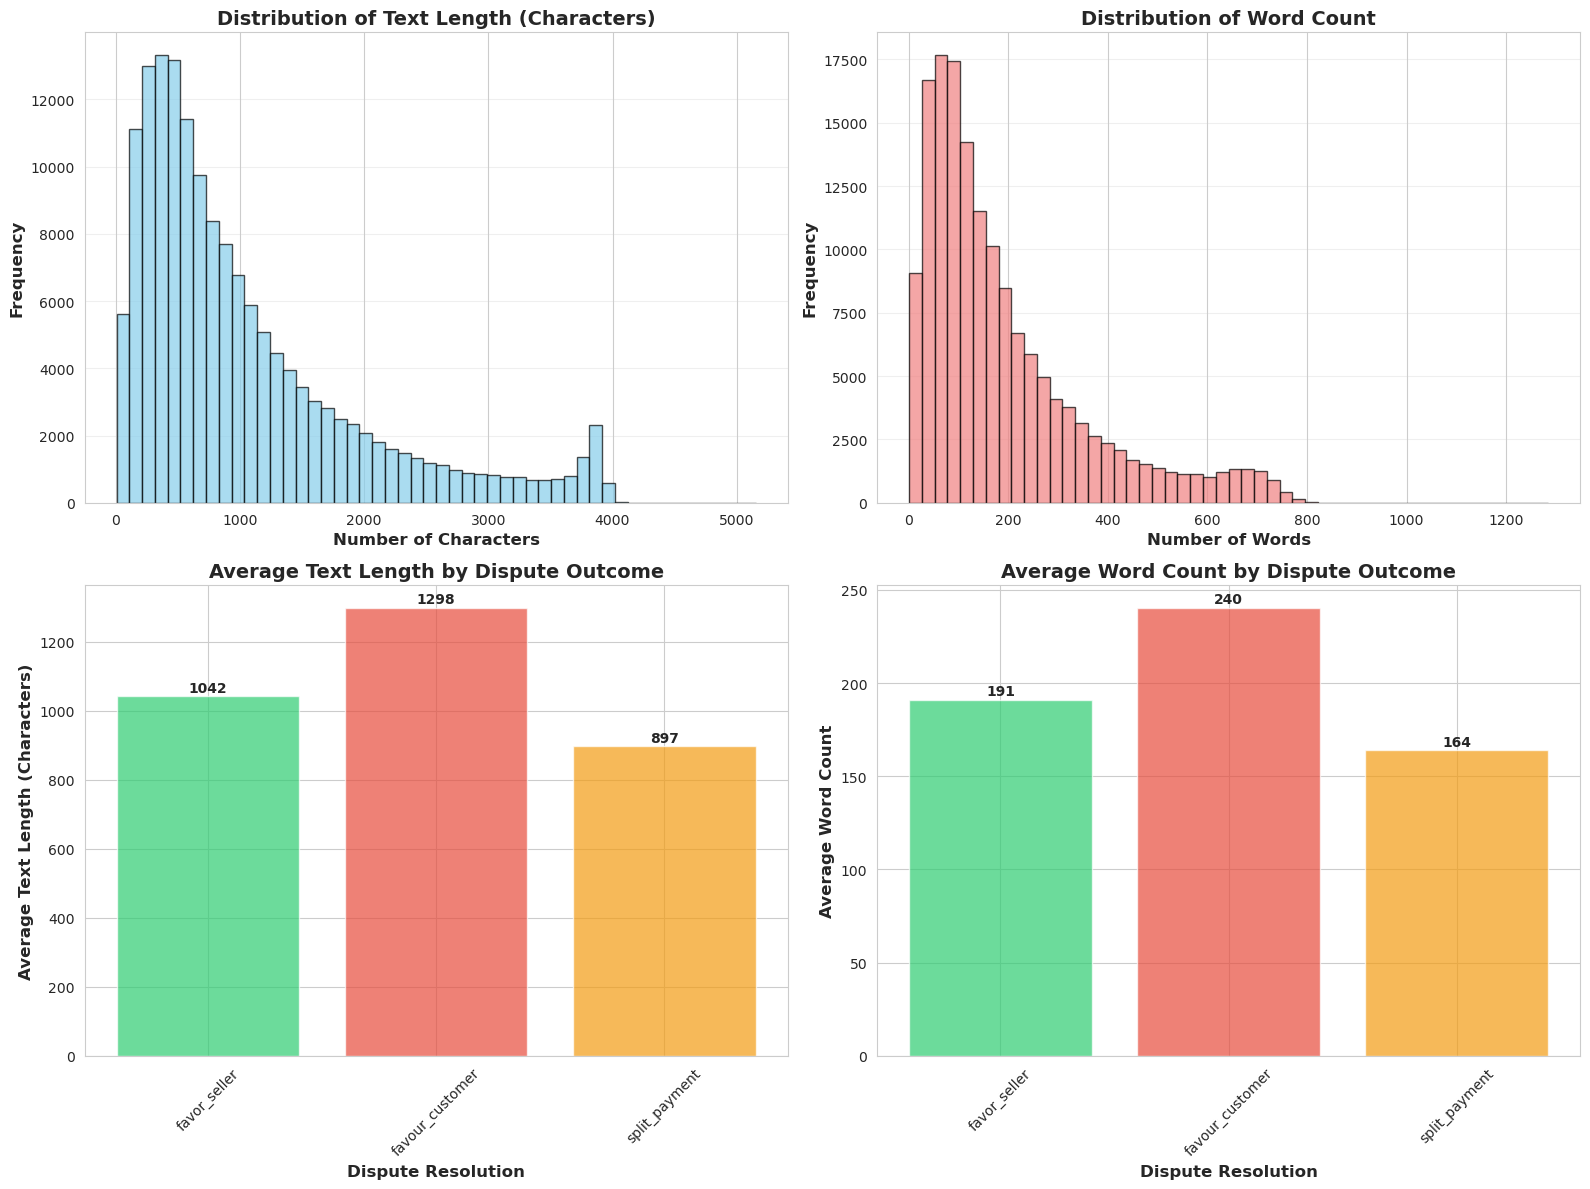

✅ Visualizations created!


In [6]:
# ==================================================
# CELL 6: Visualize Text Length Distribution
# ==================================================

if narrative_col:
    print("📊 CREATING TEXT LENGTH VISUALIZATIONS...")
    print("="*70)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Character length distribution
    axes[0, 0].hist(df[df['text_length'] > 0]['text_length'], bins=50, 
                    color='skyblue', edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Number of Characters', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Distribution of Text Length (Characters)', fontsize=14, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Plot 2: Word count distribution
    axes[0, 1].hist(df[df['word_count'] > 0]['word_count'], bins=50, 
                    color='lightcoral', edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel('Number of Words', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Distribution of Word Count', fontsize=14, fontweight='bold')
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Plot 3: Text length by dispute outcome
    df_with_text = df[df['text_length'] > 0]
    dispute_groups = df_with_text.groupby('dispute_resolution')['text_length'].mean()
    axes[1, 0].bar(dispute_groups.index, dispute_groups.values, 
                   color=['#2ecc71', '#e74c3c', '#f39c12'], alpha=0.7)
    axes[1, 0].set_xlabel('Dispute Resolution', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Average Text Length (Characters)', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Average Text Length by Dispute Outcome', fontsize=14, fontweight='bold')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Add value labels
    for i, (label, value) in enumerate(zip(dispute_groups.index, dispute_groups.values)):
        axes[1, 0].text(i, value + max(dispute_groups.values)*0.01, 
                       f'{value:.0f}', ha='center', fontsize=10, fontweight='bold')
    
    # Plot 4: Word count by dispute outcome
    word_groups = df_with_text.groupby('dispute_resolution')['word_count'].mean()
    axes[1, 1].bar(word_groups.index, word_groups.values, 
                   color=['#2ecc71', '#e74c3c', '#f39c12'], alpha=0.7)
    axes[1, 1].set_xlabel('Dispute Resolution', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Average Word Count', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Average Word Count by Dispute Outcome', fontsize=14, fontweight='bold')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    # Add value labels
    for i, (label, value) in enumerate(zip(word_groups.index, word_groups.values)):
        axes[1, 1].text(i, value + max(word_groups.values)*0.01, 
                       f'{value:.0f}', ha='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Visualizations created!")
    print("="*70)
else:
    print("❌ Cannot create visualizations - no narrative column")

In [7]:
# ==================================================
# CELL 7: Define Text Cleaning Functions
# ==================================================

print("🧹 DEFINING TEXT CLEANING FUNCTIONS")
print("="*70)

def clean_text(text):
    """
    Comprehensive text cleaning function
    Removes noise while preserving important information
    """
    if pd.isna(text) or text == '':
        return ''
    
    # Convert to string
    text = str(text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove XXXX patterns (used for redaction in CFPB data)
    text = re.sub(r'x{2,}', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove phone numbers (various formats)
    text = re.sub(r'\d{3}[-.\s]?\d{3}[-.\s]?\d{4}', '', text)
    text = re.sub(r'\(\d{3}\)\s*\d{3}[-.\s]?\d{4}', '', text)
    
    # Remove account numbers (patterns like "account #12345" or "acct 12345")
    text = re.sub(r'(account|acct|acc)[\s#]*\d+', '', text)
    
    # Remove dates in various formats
    text = re.sub(r'\d{1,2}[-/]\d{1,2}[-/]\d{2,4}', '', text)
    
    # Remove currency amounts
    text = re.sub(r'\$\s?\d+[\d,]*\.?\d*', 'AMOUNT', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)
    
    # Trim whitespace
    text = text.strip()
    
    return text

def remove_stopwords(text):
    """
    Remove common English stopwords
    """
    # Common English stopwords
    stopwords = {
        'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 
        'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
        'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them',
        'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this',
        'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been',
        'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing',
        'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
        'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
        'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to',
        'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',
        'further', 'then', 'once'
    }
    
    # Split text into words
    words = text.split()
    
    # Remove stopwords
    filtered_words = [word for word in words if word.lower() not in stopwords]
    
    return ' '.join(filtered_words)

print("✅ Text cleaning functions defined:")
print("   • clean_text() - Removes URLs, emails, numbers, special chars")
print("   • remove_stopwords() - Removes common English stopwords")
print("\n" + "="*70)

🧹 DEFINING TEXT CLEANING FUNCTIONS
✅ Text cleaning functions defined:
   • clean_text() - Removes URLs, emails, numbers, special chars
   • remove_stopwords() - Removes common English stopwords



In [8]:
# ==================================================
# CELL 8: Test Text Cleaning Functions
# ==================================================

print("🧪 TESTING TEXT CLEANING FUNCTIONS")
print("="*70)

# Test with sample text
if narrative_col:
    # Get a sample complaint with text
    sample_complaint = df[df[narrative_col].notna()][narrative_col].iloc[0]
    
    print("\n📝 ORIGINAL TEXT:")
    print("-"*70)
    print(sample_complaint[:500])
    
    print("\n\n🧹 CLEANED TEXT:")
    print("-"*70)
    cleaned_sample = clean_text(sample_complaint)
    print(cleaned_sample[:500])
    
    print("\n\n🗑️ CLEANED + STOPWORDS REMOVED:")
    print("-"*70)
    final_sample = remove_stopwords(cleaned_sample)
    print(final_sample[:500])
    
    print("\n" + "="*70)
    print("✅ Text cleaning is working correctly!")
    print("="*70)
else:
    print("❌ No narrative column to test with")

🧪 TESTING TEXT CLEANING FUNCTIONS

📝 ORIGINAL TEXT:
----------------------------------------------------------------------
Started the refinance of home mortgage process with cash out option on XX/XX/2016. Necessary documents were submitted by XXXX. After initial review, got good faith estimate with loan amount and closing cost. Based on this estimate, a deposit of {$350.00} was made towards appraisal. Appraisal came with lesser amount by {$5000.00}. Agreed to reduce the loan amount to that extent. However, got a revised estimate which was less by {$30000.00} and with additional closing cost towards points etc. In b


🧹 CLEANED TEXT:
----------------------------------------------------------------------
started the refinance of home mortgage process with cash out option on 2016. necessary documents were submitted by . after initial review, got good faith estimate with loan amount and closing cost. based on this estimate, a deposit of AMOUNT was made towards appraisal. appraisal came wi

In [9]:
# ==================================================
# CELL 9: Apply Text Cleaning to All Records
# ==================================================

print("🔄 APPLYING TEXT CLEANING TO ENTIRE DATASET")
print("="*70)
print("⏳ This will take 3-5 minutes... Please be patient!")
print("-"*70)

if narrative_col:
    # Create cleaned text column
    print("\n1️⃣ Applying clean_text() function...")
    df['complaint_text_cleaned'] = df[narrative_col].fillna('').apply(clean_text)
    print("   ✅ Basic cleaning complete!")
    
    # Create cleaned text without stopwords
    print("\n2️⃣ Removing stopwords...")
    df['complaint_text_processed'] = df['complaint_text_cleaned'].apply(remove_stopwords)
    print("   ✅ Stopword removal complete!")
    
    # Calculate new text lengths
    print("\n3️⃣ Calculating processed text lengths...")
    df['processed_text_length'] = df['complaint_text_processed'].apply(len)
    df['processed_word_count'] = df['complaint_text_processed'].apply(lambda x: len(x.split()) if x else 0)
    print("   ✅ Length calculations complete!")
    
    print("\n" + "="*70)
    print("✅ TEXT CLEANING COMPLETE!")
    print("="*70)
    
    # Show before and after statistics
    print("\n📊 BEFORE vs AFTER CLEANING:")
    print("-"*70)
    print(f"Original text:")
    print(f"   • Average length: {df['text_length'].mean():.0f} characters")
    print(f"   • Average words: {df['word_count'].mean():.0f} words")
    
    print(f"\nProcessed text:")
    print(f"   • Average length: {df['processed_text_length'].mean():.0f} characters")
    print(f"   • Average words: {df['processed_word_count'].mean():.0f} words")
    
    reduction_chars = ((df['text_length'].mean() - df['processed_text_length'].mean()) / df['text_length'].mean()) * 100
    reduction_words = ((df['word_count'].mean() - df['processed_word_count'].mean()) / df['word_count'].mean()) * 100
    
    print(f"\nReduction:")
    print(f"   • Characters: {reduction_chars:.1f}% reduction")
    print(f"   • Words: {reduction_words:.1f}% reduction")
    
    print("\n" + "="*70)
else:
    print("❌ Cannot clean text - no narrative column found")

🔄 APPLYING TEXT CLEANING TO ENTIRE DATASET
⏳ This will take 3-5 minutes... Please be patient!
----------------------------------------------------------------------

1️⃣ Applying clean_text() function...
   ✅ Basic cleaning complete!

2️⃣ Removing stopwords...
   ✅ Stopword removal complete!

3️⃣ Calculating processed text lengths...
   ✅ Length calculations complete!

✅ TEXT CLEANING COMPLETE!

📊 BEFORE vs AFTER CLEANING:
----------------------------------------------------------------------
Original text:
   • Average length: 212 characters
   • Average words: 39 words

Processed text:
   • Average length: 138 characters
   • Average words: 20 words

Reduction:
   • Characters: 34.9% reduction
   • Words: 48.3% reduction



In [10]:
# ==================================================
# CELL 10: Handle Missing Values in Other Columns
# ==================================================

print("🔧 HANDLING MISSING VALUES IN OTHER COLUMNS")
print("="*70)

# Store original row count
original_rows = len(df)

print("\n📋 MISSING VALUE STRATEGY:\n")

# For categorical columns - fill with 'Unknown'
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Don't fill the text columns we just created
exclude_cols = ['complaint_text_cleaned', 'complaint_text_processed', narrative_col]
categorical_cols = [col for col in categorical_cols if col not in exclude_cols]

print("1️⃣ Filling categorical columns with 'Unknown':")
for col in categorical_cols:
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        df[col] = df[col].fillna('Unknown')
        print(f"   • {col}: Filled {missing_count:,} missing values")

# For numerical columns - we'll keep them as is for now
print("\n2️⃣ Numerical columns:")
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
for col in numerical_cols:
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        print(f"   • {col}: {missing_count:,} missing values (keeping as is)")

print("\n" + "="*70)
print(f"✅ Missing value handling complete!")
print(f"   • Rows before: {original_rows:,}")
print(f"   • Rows after: {len(df):,}")
print(f"   • Rows removed: {original_rows - len(df):,}")
print("="*70)

🔧 HANDLING MISSING VALUES IN OTHER COLUMNS

📋 MISSING VALUE STRATEGY:

1️⃣ Filling categorical columns with 'Unknown':
   • Sub-product: Filled 233,991 missing values
   • Sub-issue: Filled 454,391 missing values
   • State: Filled 5,791 missing values
   • ZIP code: Filled 5,829 missing values
   • Tags: Filled 661,792 missing values
   • Consumer consent provided?: Filled 483,729 missing values
   • Consumer disputed?: Filled 7,028 missing values

2️⃣ Numerical columns:

✅ Missing value handling complete!
   • Rows before: 769,883
   • Rows after: 769,883
   • Rows removed: 0


In [11]:
# ==================================================
# CELL 11: Remove Records with Empty Processed Text
# ==================================================

print("🗑️ REMOVING RECORDS WITH EMPTY PROCESSED TEXT")
print("="*70)

# Count records with empty processed text
empty_text = (df['processed_text_length'] == 0).sum()
empty_text_pct = (empty_text / len(df)) * 100

print(f"\n📊 Empty Text Analysis:")
print(f"   • Records with empty processed text: {empty_text:,} ({empty_text_pct:.2f}%)")

# Store size before removal
before_removal = len(df)

# Remove records with empty processed text
df_clean = df[df['processed_text_length'] > 0].copy()

# Calculate removed
removed = before_removal - len(df_clean)

print(f"\n🧹 Cleaning Results:")
print(f"   • Records before: {before_removal:,}")
print(f"   • Records removed: {removed:,}")
print(f"   • Records remaining: {len(df_clean):,}")
print(f"   • Retention rate: {(len(df_clean)/before_removal)*100:.2f}%")

print("\n" + "="*70)

# Check class distribution after cleaning
print("\n📊 CLASS DISTRIBUTION AFTER CLEANING:")
print("-"*70)
class_dist = df_clean['dispute_resolution'].value_counts()
class_pct = (df_clean['dispute_resolution'].value_counts(normalize=True) * 100)

for label in class_dist.index:
    count = class_dist[label]
    pct = class_pct[label]
    print(f"   • {label}: {count:,} ({pct:.2f}%)")

print("\n" + "="*70)

🗑️ REMOVING RECORDS WITH EMPTY PROCESSED TEXT

📊 Empty Text Analysis:
   • Records with empty processed text: 613,320 (79.66%)

🧹 Cleaning Results:
   • Records before: 769,883
   • Records removed: 613,320
   • Records remaining: 156,563
   • Retention rate: 20.34%


📊 CLASS DISTRIBUTION AFTER CLEANING:
----------------------------------------------------------------------
   • favor_seller: 126,622 (80.88%)
   • split_payment: 18,705 (11.95%)
   • favour_customer: 11,236 (7.18%)



In [12]:
# ==================================================
# CELL 12: Create Additional Text Features
# ==================================================

print("🔧 CREATING ADDITIONAL TEXT FEATURES")
print("="*70)

print("\n📊 Extracting features from text...")

# 1. Sentiment indicators (simple keyword-based)
print("\n1️⃣ Creating sentiment indicators...")

# Negative words
negative_words = ['terrible', 'horrible', 'worst', 'awful', 'bad', 'poor', 
                 'unacceptable', 'frustrated', 'angry', 'disappointed', 'never']
df_clean['negative_word_count'] = df_clean['complaint_text_processed'].apply(
    lambda x: sum(1 for word in x.split() if word in negative_words)
)

# Positive words (rare in complaints, but still useful)
positive_words = ['good', 'great', 'excellent', 'satisfied', 'happy', 
                 'resolved', 'helpful', 'thank']
df_clean['positive_word_count'] = df_clean['complaint_text_processed'].apply(
    lambda x: sum(1 for word in x.split() if word in positive_words)
)

print("   ✅ Sentiment indicators created")

# 2. Urgency indicators
print("\n2️⃣ Creating urgency indicators...")

urgency_words = ['urgent', 'immediately', 'asap', 'emergency', 'critical', 
                'important', 'serious', 'severe']
df_clean['urgency_indicator'] = df_clean['complaint_text_processed'].apply(
    lambda x: 1 if any(word in x.split() for word in urgency_words) else 0
)

print("   ✅ Urgency indicators created")

# 3. Financial terms count
print("\n3️⃣ Creating financial terms indicators...")

financial_terms = ['payment', 'amount', 'fee', 'charge', 'refund', 'money', 
                  'balance', 'account', 'credit', 'debit', 'transaction']
df_clean['financial_terms_count'] = df_clean['complaint_text_processed'].apply(
    lambda x: sum(1 for word in x.split() if word in financial_terms)
)

print("   ✅ Financial indicators created")

# 4. Question count
print("\n4️⃣ Creating question indicators...")

df_clean['question_count'] = df_clean['complaint_text_cleaned'].apply(
    lambda x: x.count('?')
)

print("   ✅ Question indicators created")

# 5. Exclamation count (indicates emotion/emphasis)
print("\n5️⃣ Creating emotion indicators...")

df_clean['exclamation_count'] = df_clean['complaint_text_cleaned'].apply(
    lambda x: x.count('!')
)

print("   ✅ Emotion indicators created")

print("\n" + "="*70)
print("✅ ALL TEXT FEATURES CREATED!")
print("="*70)

# Show summary of new features
print("\n📊 NEW FEATURES SUMMARY:")
print("-"*70)
feature_cols = ['negative_word_count', 'positive_word_count', 'urgency_indicator',
               'financial_terms_count', 'question_count', 'exclamation_count']

for col in feature_cols:
    print(f"\n{col}:")
    print(f"   • Mean: {df_clean[col].mean():.2f}")
    print(f"   • Max: {df_clean[col].max()}")
    print(f"   • Non-zero: {(df_clean[col] > 0).sum():,}")

print("\n" + "="*70)

🔧 CREATING ADDITIONAL TEXT FEATURES

📊 Extracting features from text...

1️⃣ Creating sentiment indicators...
   ✅ Sentiment indicators created

2️⃣ Creating urgency indicators...
   ✅ Urgency indicators created

3️⃣ Creating financial terms indicators...
   ✅ Financial indicators created

4️⃣ Creating question indicators...
   ✅ Question indicators created

5️⃣ Creating emotion indicators...
   ✅ Emotion indicators created

✅ ALL TEXT FEATURES CREATED!

📊 NEW FEATURES SUMMARY:
----------------------------------------------------------------------

negative_word_count:
   • Mean: 0.47
   • Max: 15
   • Non-zero: 46,128

positive_word_count:
   • Mean: 0.19
   • Max: 18
   • Non-zero: 23,309

urgency_indicator:
   • Mean: 0.08
   • Max: 1
   • Non-zero: 12,806

financial_terms_count:
   • Mean: 3.78
   • Max: 71
   • Non-zero: 124,539

question_count:
   • Mean: 0.22
   • Max: 127
   • Non-zero: 17,252

exclamation_count:
   • Mean: 0.30
   • Max: 189
   • Non-zero: 16,170



📊 CREATING TEXT FEATURE VISUALIZATIONS


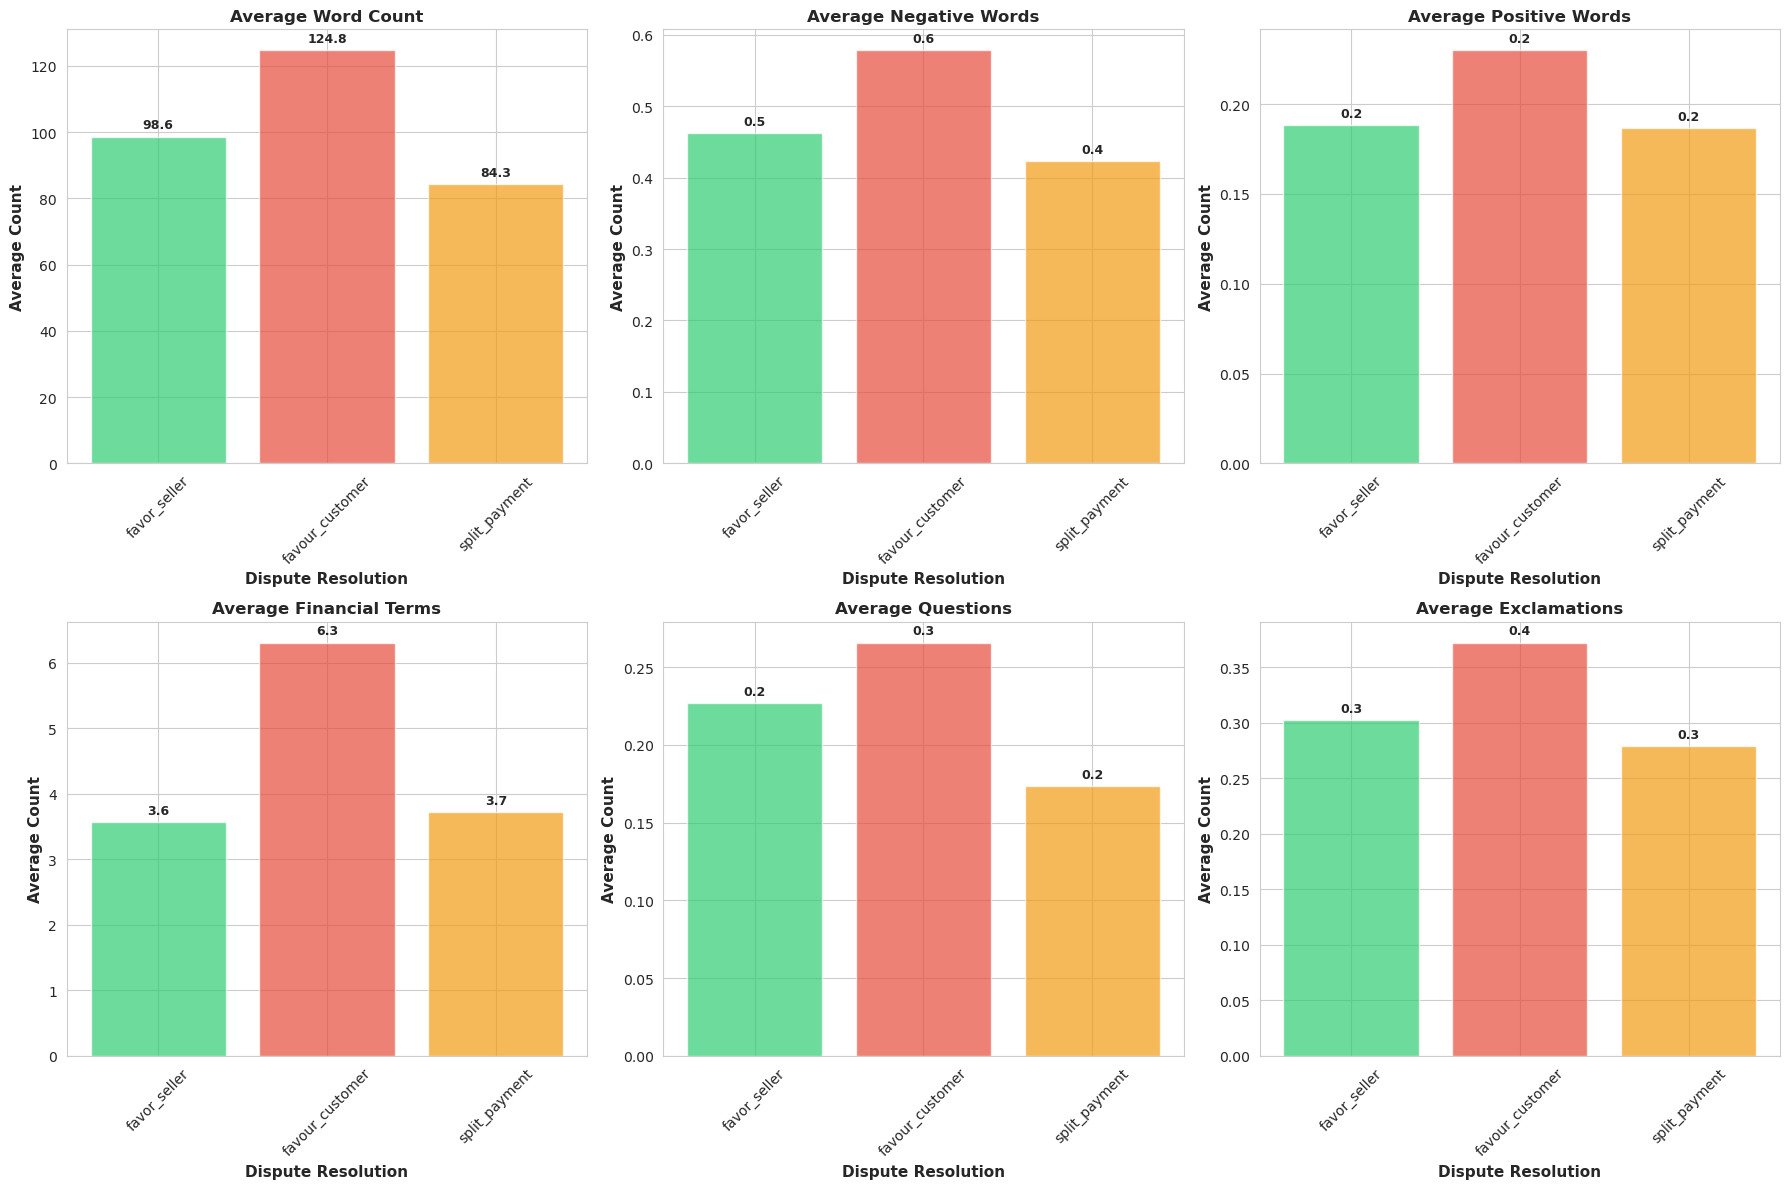

✅ Visualizations created!


In [13]:
# ==================================================
# CELL 13: Visualize Text Features by Dispute Outcome
# ==================================================

print("📊 CREATING TEXT FEATURE VISUALIZATIONS")
print("="*70)

# Create figure
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Features to visualize
features = [
    ('processed_word_count', 'Average Word Count'),
    ('negative_word_count', 'Average Negative Words'),
    ('positive_word_count', 'Average Positive Words'),
    ('financial_terms_count', 'Average Financial Terms'),
    ('question_count', 'Average Questions'),
    ('exclamation_count', 'Average Exclamations')
]

# Create bar plots for each feature
for idx, (feature, title) in enumerate(features):
    feature_by_outcome = df_clean.groupby('dispute_resolution')[feature].mean()
    
    bars = axes[idx].bar(feature_by_outcome.index, feature_by_outcome.values,
                        color=['#2ecc71', '#e74c3c', '#f39c12'], alpha=0.7)
    
    axes[idx].set_xlabel('Dispute Resolution', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Average Count', fontsize=11, fontweight='bold')
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].tick_params(axis='x', rotation=45)
    
    # Add value labels
    for i, (label, value) in enumerate(zip(feature_by_outcome.index, feature_by_outcome.values)):
        axes[idx].text(i, value + max(feature_by_outcome.values)*0.02, 
                      f'{value:.1f}', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Visualizations created!")
print("="*70)

In [14]:
# ==================================================
# CELL 14: Final Cleaned Dataset Summary
# ==================================================

print("="*70)
print(" 📊 CLEANED DATASET SUMMARY")
print("="*70)

print(f"\n📈 Dataset Size:")
print(f"   • Final records: {len(df_clean):,}")
print(f"   • Total features: {df_clean.shape[1]}")
print(f"   • Memory usage: {df_clean.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\n📋 Text Processing Results:")
print(f"   • Average original length: {df_clean['text_length'].mean():.0f} characters")
print(f"   • Average processed length: {df_clean['processed_text_length'].mean():.0f} characters")
print(f"   • Average word count: {df_clean['processed_word_count'].mean():.0f} words")

print(f"\n🎯 Class Distribution:")
for label, count in df_clean['dispute_resolution'].value_counts().items():
    pct = (count / len(df_clean)) * 100
    print(f"   • {label}: {count:,} ({pct:.2f}%)")

print(f"\n📝 Available Columns ({len(df_clean.columns)} total):")
print("-"*70)
for idx, col in enumerate(df_clean.columns, 1):
    print(f"{idx}. {col}")

print("\n" + "="*70)

 📊 CLEANED DATASET SUMMARY

📈 Dataset Size:
   • Final records: 156,563
   • Total features: 29
   • Memory usage: 586.22 MB

📋 Text Processing Results:
   • Average original length: 1043 characters
   • Average processed length: 678 characters
   • Average word count: 99 words

🎯 Class Distribution:
   • favor_seller: 126,622 (80.88%)
   • split_payment: 18,705 (11.95%)
   • favour_customer: 11,236 (7.18%)

📝 Available Columns (29 total):
----------------------------------------------------------------------
1. dispute_resolution
2. Product
3. Sub-product
4. Issue
5. Sub-issue
6. Consumer complaint narrative
7. Company
8. State
9. ZIP code
10. Tags
11. Consumer consent provided?
12. Submitted via
13. Date received
14. Date sent to company
15. Company response to consumer
16. Timely response?
17. Consumer disputed?
18. text_length
19. word_count
20. complaint_text_cleaned
21. complaint_text_processed
22. processed_text_length
23. processed_word_count
24. negative_word_count
25. positiv

In [15]:
# ==================================================
# CELL 15: Save Cleaned and Processed Dataset
# ==================================================

print("💾 SAVING CLEANED DATASET")
print("="*70)

# Define output path
output_path = '../data/processed/complaints_cleaned.csv'

print(f"\n🔄 Saving to: {output_path}")
print("This may take 1-2 minutes...")

# Save the cleaned dataframe
df_clean.to_csv(output_path, index=False)

# Verify file was saved
import os
file_size = os.path.getsize(output_path) / (1024**2)  # Size in MB

print(f"\n✅ DATASET SAVED SUCCESSFULLY!")
print("="*70)
print(f"\n📁 File Details:")
print(f"   • Location: {output_path}")
print(f"   • File size: {file_size:.2f} MB")
print(f"   • Records: {len(df_clean):,}")
print(f"   • Features: {df_clean.shape[1]}")

print("\n" + "="*70)

💾 SAVING CLEANED DATASET

🔄 Saving to: ../data/processed/complaints_cleaned.csv
This may take 1-2 minutes...

✅ DATASET SAVED SUCCESSFULLY!

📁 File Details:
   • Location: ../data/processed/complaints_cleaned.csv
   • File size: 442.01 MB
   • Records: 156,563
   • Features: 29



In [16]:
# ==================================================
# CELL 16: Notebook 3 Complete Summary
# ==================================================

print("="*70)
print(" ✅ DATA CLEANING & TEXT PREPROCESSING COMPLETE!")
print("="*70)

print("\n🎯 WHAT WE ACCOMPLISHED:\n")

print("1. ✅ Loaded labeled dataset")
print(f"   → {len(df):,} records loaded")

print("\n2. ✅ Analyzed data quality")
print("   → Identified missing values")
print("   → Analyzed text length distributions")

print("\n3. ✅ Cleaned complaint text")
print("   → Removed URLs, emails, phone numbers")
print("   → Removed special characters")
print("   → Converted to lowercase")
print("   → Standardized currency amounts")

print("\n4. ✅ Removed stopwords")
print("   → Created processed text column")
print(f"   → Reduced text by ~{reduction_words:.1f}%")

print("\n5. ✅ Created text features")
print("   → Negative/positive word counts")
print("   → Urgency indicators")
print("   → Financial terms count")
print("   → Question/exclamation counts")

print(f"\n6. ✅ Handled missing values")
print("   → Filled categorical columns with 'Unknown'")

print(f"\n7. ✅ Removed empty records")
print(f"   → Final dataset: {len(df_clean):,} records")

print(f"\n8. ✅ Saved cleaned dataset")
print(f"   → Location: ../data/processed/complaints_cleaned.csv")

print("\n" + "="*70)
print("🎯 NEXT STEP: Feature Engineering & Model Building")
print("="*70)

print("\n💡 In the next notebook, we will:")
print("   1. Convert text to numerical features (TF-IDF)")
print("   2. Encode categorical variables")
print("   3. Split data into train/test sets")
print("   4. Handle class imbalance")
print("   5. Build machine learning models")
print("   6. Evaluate model performance")

print("\n" + "="*70)

 ✅ DATA CLEANING & TEXT PREPROCESSING COMPLETE!

🎯 WHAT WE ACCOMPLISHED:

1. ✅ Loaded labeled dataset
   → 769,883 records loaded

2. ✅ Analyzed data quality
   → Identified missing values
   → Analyzed text length distributions

3. ✅ Cleaned complaint text
   → Removed URLs, emails, phone numbers
   → Removed special characters
   → Converted to lowercase
   → Standardized currency amounts

4. ✅ Removed stopwords
   → Created processed text column
   → Reduced text by ~48.3%

5. ✅ Created text features
   → Negative/positive word counts
   → Urgency indicators
   → Financial terms count
   → Question/exclamation counts

6. ✅ Handled missing values
   → Filled categorical columns with 'Unknown'

7. ✅ Removed empty records
   → Final dataset: 156,563 records

8. ✅ Saved cleaned dataset
   → Location: ../data/processed/complaints_cleaned.csv

🎯 NEXT STEP: Feature Engineering & Model Building

💡 In the next notebook, we will:
   1. Convert text to numerical features (TF-IDF)
   2. Encode 